In [1]:
# import basics
import pandas as pd
import numpy as np

# import tools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# import models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

# import viz
import altair as alt
alt.renderers.enable('mimetype') # for altair plots to be properly rendered on GH

RendererRegistry.enable('mimetype')

In [2]:
def load_X_y():
    """
    docstring to be added
    """
    df = pd.read_csv("../../data/train.csv")
    y = np.log(df['SalePrice']) # using the logarithm as the target
    X = df.drop(columns=['SalePrice', 'Id']).copy() # dropped ID col too
    
    return X, y

In [3]:
def run_base_model(X, y, make_plot=True):
    """
    docstring to be added
    """
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=9527)
    # create the list of cols to drop based on missing rate
    missing_rates = (X_train.isnull().sum()/X_train.shape[0]).sort_values(ascending=False)[:20]
    cols_drop = list(missing_rates[:5].index)

    # create list of categorical and numerical columns
    cat_cols = [x for x in X_train.columns[[(x=='object') for x in X_train.dtypes]] if x not in cols_drop]
    num_cols = [x for x in X_train.columns if (x not in cat_cols) and (x not in cols_drop)]

    assert len(cat_cols) + len(num_cols) + len(cols_drop) == X_train.shape[1]

    # define pipeline steps
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(np.nan, 'mean')),
        ('scaler', StandardScaler())
    ])

    categoric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan,
                                  strategy='most_frequent')),
        ("ohe", OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(remainder='drop', transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categoric_transformer, cat_cols)
    ])

    # define base models with default hyp-params
    model = LGBMRegressor()

    # run LGBM with 10-fold CV, RMSE scoring
    ppl = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', model)]) # create pipeline object
    ppl.fit(X_train, y_train)
    score = cross_val_score(ppl, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10).mean() * -1 # 10-fold cv RMSE score

    print("LGBM 10-fold cv RMSE: {:.3f}".format(score))

    # get ohe column names
    ohe_col_names = ppl['preprocessor'].transformers_[1][1]['ohe'].get_feature_names(cat_cols)

    ftr_imptns = ppl['regressor'].feature_importances_

    assert len(num_cols) + len(ohe_col_names)  == len(ftr_imptns)

    mdl_col_names = num_cols + list(ohe_col_names)

    # visualize LGBM important features

    ftr_imptns_df = pd.DataFrame({"feature": mdl_col_names,
                 "importance": ftr_imptns})
    ftr_imptns_df = ftr_imptns_df.sort_values('importance', ascending = False).reset_index(drop=True)

    n = 30 # how many top features to display in the plot
    bars = alt.Chart(ftr_imptns_df.iloc[:n, :]).mark_bar().encode(
        x='importance:Q',
        y=alt.Y('feature:O', sort='-x')
    )
    
    if make_plot==True:
        return bars.properties(
            title="LGBM - feature importance (top30)"
        )
    else:
        return

LGBM 10-fold cv RMSE: 0.133


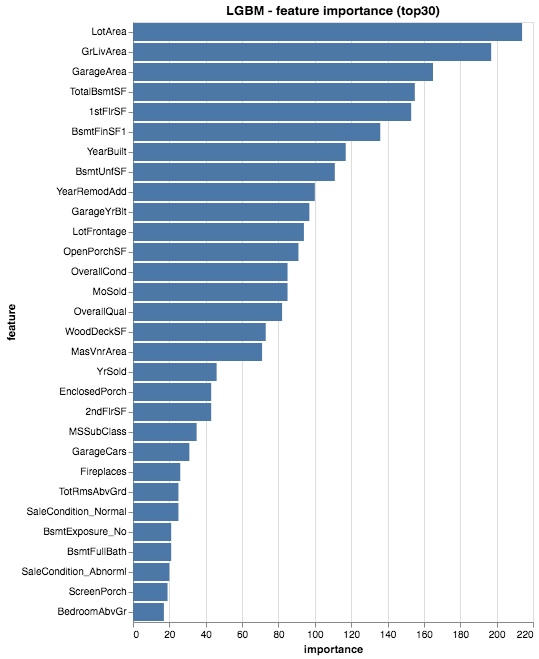

In [4]:
X, y = load_X_y()
run_base_model(X, y, make_plot=True)

## ideas for feature engineering:  
1. Make sure numerical and categorical features are accurately classified.(Some numeric features are actually categorical, while some categorical features could be numerical.)  
2. Try to synthesize some new features. 

### <font color='blue'>transfer categorical type of cols to numerical type</font> 

In [5]:
cat_to_num_cols_1 = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
cat_to_num_dict_1 = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.NaN: 0}
cat_to_num_cols_2 = ['BsmtExposure']
cat_to_num_dict_2 = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, np.NaN: 0}
cat_to_num_cols_3 = ['BsmtFinType1', 'BsmtFinType2']
cat_to_num_dict_3 = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, np.NaN: 0}
cat_to_num_cols_4 = ['GarageFinish']
cat_to_num_dict_4 = {'Fin': 3, 'RFn': 2, 'Unf': 1, np.NaN: 0}
cat_to_num_cols_5 = ['Fence']
cat_to_num_dict_5 = {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, np.NaN: 0}

In [6]:
def cat_to_num(X):
    """
    docstring to be added
    """
    temp = X.copy()
    for x in range(1, 6):
        cols = eval('cat_to_num_cols_' + str(x))
        d = eval('cat_to_num_dict_' + str(x))
        for y in cols: 
            temp[y].replace(d, inplace=True)
    return temp

### <font color='red'>test [doesn't work]</font> 

In [7]:
X, y = load_X_y()
X = cat_to_num(X)
run_base_model(X, y, make_plot=False)

LGBM 10-fold cv RMSE: 0.131


### <font color='blue'>create a ftr to sum up all the Areas</font> 

In [49]:
def create_total_area(X, area_cols, sqr_feet_cols):
    """
    docstring to be added
    """
    
    X['total_area'] = X[area_cols].sum(axis=1)
    X['total_sqr_feet'] = X[sqr_feet_cols].sum(axis=1)
    X['total_area_sqr_feet'] = X['total_area'] + X['total_sqr_feet']
    
    return X

### <font color='green'>test [works]</font> 

LGBM 10-fold cv RMSE: 0.136


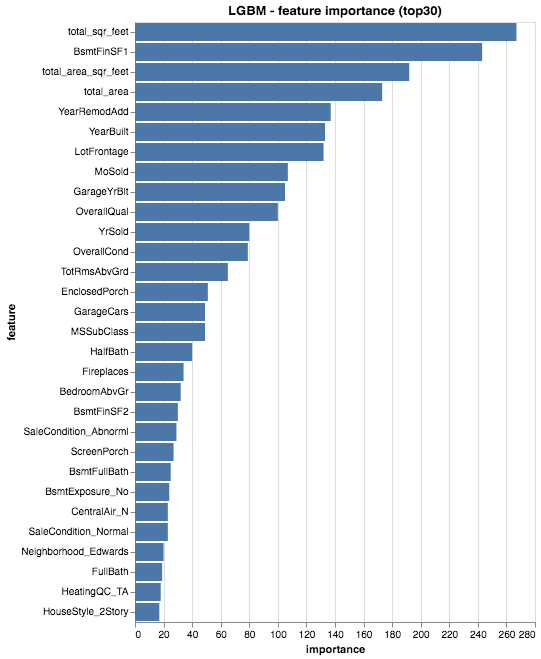

In [51]:
X, y = load_X_y()
area_cols = [x for x in X.columns if x[-4:]=='Area']
sqr_feet_cols = [x for x in X.columns if x[-2:]=='SF']

X = create_total_area(X, area_cols, sqr_feet_cols)
X = X.drop(columns=(area_cols + sqr_feet_cols))

run_base_model(X, y)

### <font color='blue'>create a ftr to sum up all the Areas</font> 